In [1]:
import numpy as np
import io
import os
from decord import VideoReader,cpu
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
import skvideo.io
from lipreading.utils.face_tracker.bot_sort import BoTSORT

/group_homes/public_cluster/home/share/LipReadingGroup/enviroment/anaconda3/envs/cuda11.7-torch1.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = '/group_homes/public_cluster/home/share/LipReadingGroup/data/LRW-preprocess/face_detect_results'
data_root = '/group_homes/public_cluster/home/share/LipReadingGroup/data/LRW'
det_results = os.listdir(root)

In [60]:
multi_person = []
shorter_than_whole = []
far_from_center = []

for item in tqdm(det_results):
    annotation = np.load(os.path.join(root,item),allow_pickle=True).item()
    video_path = os.path.join(data_root,annotation['path']+'.mp4')
    with open(video_path, 'rb') as f:
        vr = VideoReader(f, ctx=cpu())
    all_bboxes,all_kpss = annotation['bboxes'],annotation['kpss']
    tracks = []
    tracker = BoTSORT(None,0.4,0.1,0.4,0.7,30,0.5,0.25,25)
    clip = vr[:].asnumpy()
    history = {}
    history_center_dist = {}
    for fid,(frame,bbox,kps) in enumerate(zip(clip,all_bboxes,all_kpss)):
        online_targets = tracker.update(
            bbox.astype(np.float32),
            kps.astype(np.float32),
            frame)
        for i in online_targets:
            if i.track_id in history:  
                history[i.track_id].append((fid,i.tlbr))
                history_center_dist[i.track_id].append(np.linalg.norm(i.tlbr[:2] + i.tlbr[2:] / 2 - np.array([128,128])))
            else:
                history[i.track_id] = [(fid,i.tlbr)]
                history_center_dist[i.track_id] = [np.linalg.norm(i.tlbr[:2] + i.tlbr[2:] / 2 - np.array([128,128]))]
    nearest_dist = 256
    nearest_id = -1
    if len(history.keys()) > 1:
        # multi_person
        with open('multi_person.txt','a') as f:
            f.write(item+'\n')
    for i in history.keys():
        if len(history[i]) > 20:
            mean_dist = sum(history_center_dist[i]) / len(history_center_dist[i])
            if mean_dist < nearest_dist:
                nearest_id = i
                nearest_dist = mean_dist
    assert nearest_id != -1
    if nearest_dist > 35:
        # far_from_center
        with open('far_from_center.txt','a') as f:
            f.write(item+'\n')
    select_track = history[nearest_id]
    if len(select_track) < 25:
        # shorter_than_whole
        with open('shorter_than_whole.txt','a') as f:
            f.write(item+'\n')
        
    # 对空白进行补全
    complete_track = [select_track[0][1] for _ in range(select_track[0][0])]
    for i in range(len(select_track) - 1):
        complete_track.append(select_track[i][1])
        for _ in range(select_track[i+1][0] - select_track[i][0] - 1):
            complete_track.append(select_track[i][1])

    for _ in range(29 - len(complete_track)):
        complete_track.append(select_track[-1][1])
    assert len(complete_track) == 29
    new_annotation = {'path':annotation['path'],'track':complete_track}
    np.save(os.path.join(root,item).replace('face_detect_results','face_detect_results_v2'),new_annotation)

  0%|          | 60/538766 [00:07<19:03:39,  7.85it/s]


KeyboardInterrupt: 

In [61]:
mean_dist

58.649639375064545

In [50]:
complete_track = [select_track[0][1] for _ in range(select_track[0][0])]
    
for i in range(len(select_track) - 1):
    complete_track.append(select_track[i][1])
    for _ in range(select_track[i+1][0] - select_track[i][0] - 1):
        complete_track.append(select_track[i][1])

for _ in range(29 - len(complete_track)):
    complete_track.append(select_track[-1][1])


In [49]:
select_track[-1][0]

25

In [52]:
complete_track

[array([ 61.76862174,  20.92896261, 185.10233096, 201.62227215]),
 array([ 61.76862174,  20.92896261, 185.10233096, 201.62227215]),
 array([ 61.76862174,  20.92896261, 185.10233096, 201.62227215]),
 array([ 61.76862174,  20.92896261, 185.10233096, 201.62227215]),
 array([ 61.8896564 ,  21.13717047, 185.29792882, 202.42820857]),
 array([ 61.33435675,  20.77378841, 184.85898068, 202.01709681]),
 array([ 61.73565815,  20.21137727, 185.4439923 , 201.54780942]),
 array([ 62.44759209,  19.84450202, 186.52198676, 201.47593192]),
 array([ 63.19455389,  19.3519713 , 187.66976729, 202.46161701]),
 array([ 62.80110861,  19.16700109, 187.14362237, 202.74710801]),
 array([ 62.80110861,  19.16700109, 187.14362237, 202.74710801]),
 array([ 62.82628375,  17.14064832, 186.718348  , 200.81387252]),
 array([ 62.00512871,  18.42530976, 185.9722437 , 201.96164484]),
 array([ 62.00512871,  18.42530976, 185.9722437 , 201.96164484]),
 array([ 61.75986103,  19.12860507, 185.83412198, 202.76830193]),
 array([ 6

In [43]:
complete_track

(3, array([ 61.76862174,  20.92896261, 185.10233096, 201.62227215]))

In [17]:
annotation = np.load(os.path.join(root,item),allow_pickle=True).item()
video_path = os.path.join(data_root,annotation['path']+'.mp4')
with open(video_path, 'rb') as f:
    vr = VideoReader(f, ctx=cpu())
all_bboxes,all_kpss = annotation['bboxes'],annotation['kpss']
tracks = []
tracker = BoTSORT(None,0.4,0.1,0.4,0.7,30,0.5,0.25,25)
clip = vr[:].asnumpy()
history = {}
center_dist = {}
history_cnt = {}
for frame,bbox,kps in zip(clip,all_bboxes,all_kpss):
    online_targets = tracker.update(
        bbox.astype(np.float32),
        kps.astype(np.float32),
        frame)
    for i in online_targets:
        if i.track_id in history:  
            history[i.track_id].append(i.tlbr)
            history_cnt[i.track_id] += 1
            center_dist[i.track_id] = 
        else:
            history[i.track_id] = [i.tlbr]
            history_cnt[i.track_id] = 1

In [27]:
i.tlbr[:2] + i.tlbr[2:] / 2

array([149.04806689, 122.29919523])

In [26]:
history

{1: [array([ 72.75   ,  37.03125, 196.125  , 194.75   ]),
  array([ 72.28757389,  37.15140782, 196.66295075, 195.98588335]),
  array([ 72.10907807,  37.01226725, 197.02987872, 195.44196087]),
  array([ 73.63044254,  37.12314845, 197.18857979, 193.67553178]),
  array([ 73.10001201,  37.30603043, 195.80475284, 194.13037204]),
  array([ 71.42787177,  35.34102295, 194.22123576, 193.65092533]),
  array([ 72.44771096,  36.76082117, 194.74656949, 194.45041866]),
  array([ 70.99298018,  39.14481841, 193.25225236, 195.09292077]),
  array([ 71.04556213,  38.29191595, 193.63631995, 194.71875338]),
  array([ 71.01810188,  36.72559853, 193.35448092, 194.70797382]),
  array([ 68.2653548 ,  37.04389922, 191.95648724, 195.75400063]),
  array([ 67.96532101,  38.44615694, 192.04675007, 197.15612126]),
  array([ 67.91068312,  39.15009155, 191.22985334, 196.7881198 ]),
  array([ 65.59907895,  39.72042147, 189.27559195, 196.75445875]),
  array([ 64.06474294,  40.07786228, 188.8324313 , 196.53758389]),
  ar

In [9]:
sort_tracks = {}
for ts in tracks:
    for t in ts:
        

[[OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13),
  OT_7_(1-3)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13),
  OT_7_(1-3)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13),
  OT_7_(1-3)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_5_(1-11),
  OT_6_(1-13)],
 [OT_1_(1-29), OT_2_(1-17), OT_3_(1-15), OT_4_(1-19), OT_6_(1-13), OT_8_(8-8)],
 [OT_1_(1-29), OT_2_(1-17), OT_3_(1-15), OT_4_(1-19), OT_6_(1-13)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_6_(1-13),
  OT_5_(1-11)],
 [OT_1_(1-29),
  OT_2_(1-17),
  OT_3_(1-15),
  OT_4_(1-19),
  OT_6_(1-13),
  OT_5_

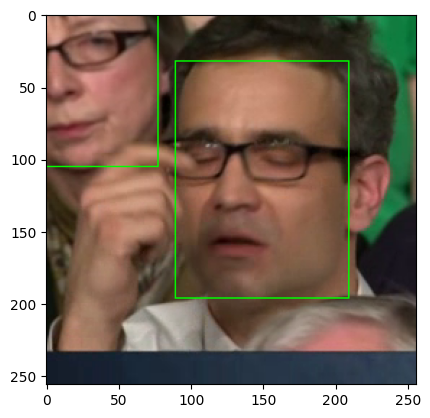

In [31]:
plt.imshow(frames[10])

In [11]:
online_targets

[OT_1_(1-29)]

In [5]:
annotation.keys()

dict_keys(['path', 'bboxes', 'kpss'])

In [1]:
import numpy as np
import io
import os
from scenedetect import SceneManager, open_video, ContentDetector
from decord import VideoReader,cpu
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from lipreading.utils.face_tracker.bot_sort import BoTSORT
from lipreading.utils.face_recognition import FaceRecognizer
from lipreading.utils.face_detector import FaceDetector

/group_homes/public_cluster/home/share/LipReadingGroup/enviroment/anaconda3/envs/cuda11.7-torch1.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = '/group_homes/public_cluster/home/share/LipReadingGroup/data/LRS2-preprocess/face_detect_results'
data_root = '/group_homes/public_cluster/home/share/LipReadingGroup/data/LRS2'
det_results = os.listdir(root)
reid_model = FaceRecognizer('/group_homes/public_cluster/home/share/LipReadingGroup/lipreading/checkpoints/glintr100.onnx')

In [3]:
def get_color(idx):
    idx *= 3
    color = ((37*idx)%255,(17*idx)%255,(29*idx)%255)
    return color

In [25]:
for item in tqdm(det_results):
    annotation = np.load(os.path.join(root,item),allow_pickle=True).item()
    video_path = os.path.join(data_root,annotation['path']+'.mp4')
    scence_threshold = 27
    video = open_video(video_path)
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=scence_threshold))
    # Detect all scenes in video from current position to end.
    scene_manager.detect_scenes(video)
    # 根据视频分割读取片段
    seg = scene_manager.get_scene_list()
    with open(video_path, 'rb') as f:
        vr = VideoReader(f, ctx=cpu())
    # 读取检测结果
    all_bboxes,all_kpss = annotation['bboxes'],annotation['kpss']
    tracks = []
    tracker = BoTSORT(reid_model,0.4,0.1,0.4,0.7,30,0.5,0.25,25)

    if len(seg) > 0:
        reid = False
        cal_reid_only = False
        for clip in seg[:-1]:
            start,end = clip
            start,end = start.frame_num, end.frame_num
            clip = vr[start:end].asnumpy()
            bboxes,kpss = all_bboxes[start:end],all_kpss[start:end]
            for index,(frame,bbox,kps) in enumerate(zip(clip,bboxes,kpss)):
                online_targets = tracker.update(
                    bbox.astype(np.float32),
                    kps.astype(np.float32),
                    frame,reid,cal_reid_only)
                tracks.append(online_targets)
                if index == len(clip) - 2:
                    # 当前clip最后一帧，提取reid特征
                    reid = False
                    cal_reid_only = True
                elif reid:
                    reid = False
                    cal_reid_only = False

            reid = True
            cal_reid_only = False

        start,_ = seg[-1]
        start = start.frame_num
        clip = vr[start:].asnumpy()
        bboxes,kpss = all_bboxes[start:],all_kpss[start:]
        for frame,bbox,kps in zip(clip,bboxes,kpss):
            online_targets = tracker.update(
                bbox.astype(np.float32),
                kps.astype(np.float32),
                frame,reid,cal_reid_only)
            tracks.append(online_targets)
            if reid:
                reid = False
                cal_reid_only = False
    else:
        clip = vr[:].asnumpy()
        bboxes,kpss = all_bboxes,all_kpss
        for frame,bbox,kps in zip(clip,bboxes,kpss):
            online_targets = tracker.update(
                bbox.astype(np.float32),
                kps.astype(np.float32),
                frame)
            tracks.append(online_targets)

  0%|          | 141/143400 [00:23<6:32:56,  6.08it/s] 


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
input_size = (640,640)
model_ratio = float(input_size[1]) / input_size[0]
det_batch_size = 16
detector = FaceDetector('../checkpoints/scrfd_10g_gnkps.onnx','CUDA')

2023-02-05 21:08:01.574536385 [W:onnxruntime:, session_state.cc:1030 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.


In [5]:
def face_det(video,detector):
    video_bboxes = []
    video_kps = []
    video_scores = []
    img_shape = video[0].shape
    im_ratio = float(img_shape[0]) / img_shape[1]

    if im_ratio > model_ratio:
        new_height = input_size[1]
        new_width = int(new_height / im_ratio)
    else:
        new_width = input_size[0]
        new_height = int(new_width * im_ratio)
    det_scale = float(new_height) / img_shape[0]

    resize_video = []
    for i in range(len(video)):
        frame = cv2.resize(video[i], (new_width, new_height))
        det_img = np.zeros((input_size[1], input_size[0], 3), dtype=np.uint8 )
        det_img[:new_height, :new_width, :] = frame
        resize_video.append(det_img)
    resize_video = np.stack(resize_video)
    blob = cv2.dnn.blobFromImages(resize_video, 1.0/128, input_size, (127.5, 127.5, 127.5), swapRB=False)
    for chunk in np.array_split(blob, math.ceil(len(blob)/det_batch_size)):
        bboxes,kpss = detector.detect(chunk,0.1)
        bboxes = [np.hstack([i[:,:4]/det_scale,i[:,[4]]]) for i in bboxes]
        kpss = [i/det_scale for i in kpss]
        video_bboxes.extend(bboxes)
        video_kps.extend(kpss)
    return video_bboxes,video_kps

2023-02-05 21:08:01.574569637 [W:onnxruntime:, session_state.cc:1032 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [6]:
video_path = 'output.mp4'
scence_threshold = 27
video = open_video(video_path)
scene_manager = SceneManager()
scene_manager.add_detector(
    ContentDetector(threshold=scence_threshold))
# Detect all scenes in video from current position to end.
scene_manager.detect_scenes(video)
# 根据视频分割读取片段
seg = scene_manager.get_scene_list()
with open(video_path, 'rb') as f:
    vr = VideoReader(f, ctx=cpu())
# 读取检测结果

tracks = []
tracker = BoTSORT(reid_model,0.4,0.1,0.4,0.7,30,0.5,0.25,25)

if len(seg) > 0:
    reid = False
    cal_reid_only = False
    for clip in seg[:-1]:
        start,end = clip
        start,end = start.frame_num, end.frame_num
        clip = vr[start:end].asnumpy()
        bboxes,kpss = face_det(clip,detector)

        for index,(frame,bbox,kps) in enumerate(zip(clip,bboxes,kpss)):
            online_targets = tracker.update(
                bbox.astype(np.float32),
                kps.astype(np.float32),
                frame,reid,cal_reid_only)
            tracks.append(online_targets)
            if index == len(clip) - 2:
                # 当前clip最后一帧，提取reid特征
                reid = False
                cal_reid_only = True
            elif reid:
                reid = False
                cal_reid_only = False
            
                
        reid = True
        cal_reid_only = False
        
    start,_ = seg[-1]
    start = start.frame_num
    clip = vr[start:].asnumpy()
    bboxes,kpss = face_det(clip,detector)
    for frame,bbox,kps in zip(clip,bboxes,kpss):
        online_targets = tracker.update(
            bbox.astype(np.float32),
            kps.astype(np.float32),
            frame,reid,cal_reid_only)
        tracks.append(online_targets)
        if reid:
            reid = False
            cal_reid_only = False
else:
    clip = vr[:].asnumpy()
    bboxes,kpss = all_bboxes,all_kpss
    for frame,bbox,kps in zip(clip,bboxes,kpss):
        online_targets = tracker.update(
            bbox.astype(np.float32),
            kps.astype(np.float32),
            frame)
        tracks.append(online_targets)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [15]:
seg[:4]

[(00:00:00.000 [frame=0, fps=25.000], 00:00:00.680 [frame=17, fps=25.000]),
 (00:00:00.680 [frame=17, fps=25.000], 00:00:01.280 [frame=32, fps=25.000]),
 (00:00:01.280 [frame=32, fps=25.000], 00:00:01.880 [frame=47, fps=25.000]),
 (00:00:01.880 [frame=47, fps=25.000], 00:00:03.080 [frame=77, fps=25.000])]

In [12]:
start

47

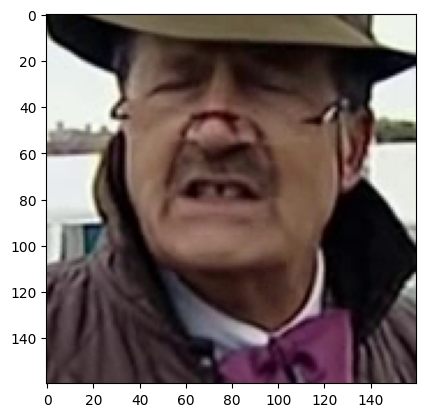

In [28]:
plt.imshow(vr[100].asnumpy())

In [6]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

from lipreading.utils.face_tracker import matching
from lipreading.utils.face_tracker.gmc import GMC
from lipreading.utils.face_tracker.basetrack import BaseTrack, TrackState
from lipreading.utils.face_tracker.kalman_filter import KalmanFilter
from lipreading.utils.face_align import norm_crop_batched

class STrack(BaseTrack):
    shared_kalman = KalmanFilter()

    def __init__(self, tlwh, score, feat=None, feat_history=50):

        # wait activate
        self._tlwh = np.asarray(tlwh, dtype=np.float)
        self.kalman_filter = None
        self.mean, self.covariance = None, None
        self.is_activated = False

        self.score = score
        self.tracklet_len = 0

        self.smooth_feat = None
        self.curr_feat = None
        if feat is not None:
            self.update_features(feat)
        self.features = deque([], maxlen=feat_history)
        self.alpha = 0.9

    def update_features(self, feat):
        feat /= np.linalg.norm(feat)
        self.curr_feat = feat
        if self.smooth_feat is None:
            self.smooth_feat = feat
        else:
            self.smooth_feat = self.alpha * self.smooth_feat + (1 - self.alpha) * feat
        self.features.append(feat)
        self.smooth_feat /= np.linalg.norm(self.smooth_feat)

    def predict(self):
        mean_state = self.mean.copy()
        if self.state != TrackState.Tracked:
            mean_state[6] = 0
            mean_state[7] = 0

        self.mean, self.covariance = self.kalman_filter.predict(mean_state, self.covariance)

    @staticmethod
    def multi_predict(stracks):
        if len(stracks) > 0:
            multi_mean = np.asarray([st.mean.copy() for st in stracks])
            multi_covariance = np.asarray([st.covariance for st in stracks])
            for i, st in enumerate(stracks):
                if st.state != TrackState.Tracked:
                    multi_mean[i][6] = 0
                    multi_mean[i][7] = 0
            multi_mean, multi_covariance = STrack.shared_kalman.multi_predict(multi_mean, multi_covariance)
            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                stracks[i].mean = mean
                stracks[i].covariance = cov

    @staticmethod
    def multi_gmc(stracks, H=np.eye(2, 3)):
        if len(stracks) > 0:
            multi_mean = np.asarray([st.mean.copy() for st in stracks])
            multi_covariance = np.asarray([st.covariance for st in stracks])

            R = H[:2, :2]
            R8x8 = np.kron(np.eye(4, dtype=float), R)
            t = H[:2, 2]

            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                mean = R8x8.dot(mean)
                mean[:2] += t
                cov = R8x8.dot(cov).dot(R8x8.transpose())

                stracks[i].mean = mean
                stracks[i].covariance = cov

    def activate(self, kalman_filter, frame_id):
        """Start a new tracklet"""
        self.kalman_filter = kalman_filter
        self.track_id = self.next_id()

        self.mean, self.covariance = self.kalman_filter.initiate(self.tlwh_to_xywh(self._tlwh))

        self.tracklet_len = 0
        self.state = TrackState.Tracked
        if frame_id == 1:
            self.is_activated = True
        self.frame_id = frame_id
        self.start_frame = frame_id

    def re_activate(self, new_track, frame_id, new_id=False):

        self.mean, self.covariance = self.kalman_filter.update(self.mean, self.covariance, self.tlwh_to_xywh(new_track.tlwh))
        if new_track.curr_feat is not None:
            self.update_features(new_track.curr_feat)
        self.tracklet_len = 0
        self.state = TrackState.Tracked
        self.is_activated = True
        self.frame_id = frame_id
        if new_id:
            self.track_id = self.next_id()
        self.score = new_track.score

    def update(self, new_track, frame_id):
        """
        Update a matched track
        :type new_track: STrack
        :type frame_id: int
        :type update_feature: bool
        :return:
        """
        self.frame_id = frame_id
        self.tracklet_len += 1

        new_tlwh = new_track.tlwh

        self.mean, self.covariance = self.kalman_filter.update(self.mean, self.covariance, self.tlwh_to_xywh(new_tlwh))

        if new_track.curr_feat is not None:
            self.update_features(new_track.curr_feat)

        self.state = TrackState.Tracked
        self.is_activated = True

        self.score = new_track.score

    @property
    def tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
                width, height)`.
        """
        if self.mean is None:
            return self._tlwh.copy()
        ret = self.mean[:4].copy()
        ret[:2] -= ret[2:] / 2
        return ret

    @property
    def tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    @property
    def xywh(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[:2] += ret[2:] / 2.0
        return ret

    @staticmethod
    def tlwh_to_xyah(tlwh):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

    @staticmethod
    def tlwh_to_xywh(tlwh):
        """Convert bounding box to format `(center x, center y, width,
        height)`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        return ret

    def to_xywh(self):
        return self.tlwh_to_xywh(self.tlwh)

    @staticmethod
    def tlbr_to_tlwh(tlbr):
        ret = np.asarray(tlbr).copy()
        ret[2:] -= ret[:2]
        return ret

    @staticmethod
    def tlwh_to_tlbr(tlwh):
        ret = np.asarray(tlwh).copy()
        ret[2:] += ret[:2]
        return ret

    def __repr__(self):
        return 'OT_{}_({}-{})'.format(self.track_id, self.start_frame, self.end_frame)


class BoTSORT(object):
    def __init__(self, 
                 reid_model,
                 track_high_thresh,
                 track_low_thresh,
                 new_track_thresh,
                 match_thresh, 
                 track_buffer,
                 proximity_thresh,
                 appearance_thresh,
                 frame_rate=30):

        self.tracked_stracks = []  # type: list[STrack]
        self.lost_stracks = []  # type: list[STrack]
        self.removed_stracks = []  # type: list[STrack]
        BaseTrack.clear_count()

        self.frame_id = 0

        self.track_high_thresh = track_high_thresh
        self.track_low_thresh = track_low_thresh
        self.new_track_thresh = new_track_thresh
        self.match_thresh = match_thresh

        self.buffer_size = int(frame_rate / 30.0 * track_buffer)
        self.max_time_lost = self.buffer_size
        self.kalman_filter = KalmanFilter()

        # ReID module
        self.proximity_thresh = proximity_thresh
        self.appearance_thresh = appearance_thresh
        
        self.encoder = reid_model

        self.gmc = GMC()

    def update(self, bboxes,kps, img,with_reid = False,cal_reid_only = False):
        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []
        if len(bboxes):
            scores = bboxes[:, 4]
            bboxes = bboxes[:, :4] # x1y1x2y2
 
            # Remove bad detections
            lowest_inds = scores > self.track_low_thresh
            bboxes = bboxes[lowest_inds]
            scores = scores[lowest_inds]
            kps = kps[lowest_inds]

            # Find high threshold detections
            remain_inds = scores > self.track_high_thresh
            dets = bboxes[remain_inds]
            scores_keep = scores[remain_inds]
            kps_keep = kps[remain_inds]

        else:
            bboxes = []
            scores = []
            dets = []
            scores_keep = []

        '''Extract embeddings '''
        if with_reid or cal_reid_only:
            crops = norm_crop_batched(img,kps_keep)
            features_keep = []
            for crop in crops:
                features_keep.append(self.encoder(crop)[0])
                
        if len(dets) > 0:
            '''Detections'''
            if with_reid or cal_reid_only:
                detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s, f) for
                          (tlbr, s, f) in zip(dets, scores_keep, features_keep)]
            else:
                detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                              (tlbr, s) in zip(dets, scores_keep)]
        else:
            detections = []

        ''' Add newly detected tracklets to tracked_stracks'''
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_stracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        ''' Step 2: First association, with high score detection boxes'''
        strack_pool = joint_stracks(tracked_stracks, self.lost_stracks)
        # Predict the current location with KF
        STrack.multi_predict(strack_pool)

        # Fix camera motion
        warp = self.gmc.apply(img, dets)
        STrack.multi_gmc(strack_pool, warp)
        STrack.multi_gmc(unconfirmed, warp)

        # Associate with high score detection boxes
        ious_dists = matching.iou_distance(strack_pool, detections)
        ious_dists_mask = (ious_dists > self.proximity_thresh)

        ious_dists = matching.fuse_score(ious_dists, detections)
        if with_reid:
            emb_dists = matching.embedding_distance(strack_pool, detections) / 2.0
            emb_dists[emb_dists > self.appearance_thresh] = 1.0
            emb_dists[ious_dists_mask] = 1.0
            dists = emb_dists
            # dists = np.minimum(ious_dists, emb_dists)
        else:
            dists = ious_dists
            
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=self.match_thresh)

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        ''' Step 3: Second association, with low score detection boxes'''
        if len(scores):
            inds_high = scores < self.track_high_thresh
            inds_low = scores > self.track_low_thresh
            inds_second = np.logical_and(inds_low, inds_high)
            dets_second = bboxes[inds_second]
            scores_second = scores[inds_second]
        else:
            dets_second = []
            scores_second = []

        # association the untrack to the low score detections
        if len(dets_second) > 0:
            '''Detections'''
            detections_second = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                                 (tlbr, s) in zip(dets_second, scores_second)]
        else:
            detections_second = []

        r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
        dists = matching.iou_distance(r_tracked_stracks, detections_second)
        matches, u_track, u_detection_second = matching.linear_assignment(dists, thresh=0.5)
        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections_second[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
        detections = [detections[i] for i in u_detection]
        ious_dists = matching.iou_distance(unconfirmed, detections)
        ious_dists_mask = (ious_dists > self.proximity_thresh)
        ious_dists = matching.fuse_score(ious_dists, detections)
        
        if with_reid:
            emb_dists = matching.embedding_distance(unconfirmed, detections) / 2.0
            raw_emb_dists = emb_dists.copy()
            emb_dists[emb_dists > self.appearance_thresh] = 1.0
            emb_dists[ious_dists_mask] = 1.0
            dists = emb_dists
            # dists = np.minimum(ious_dists, emb_dists)
        else:
            dists = ious_dists

        matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.new_track_thresh:
                continue

            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)

        """ Step 5: Update state"""
        for track in self.lost_stracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        """ Merge """
        self.tracked_stracks = [t for t in self.tracked_stracks if t.state == TrackState.Tracked]
        self.tracked_stracks = joint_stracks(self.tracked_stracks, activated_starcks)
        self.tracked_stracks = joint_stracks(self.tracked_stracks, refind_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.tracked_stracks)
        self.lost_stracks.extend(lost_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.removed_stracks)
        self.removed_stracks.extend(removed_stracks)
        self.tracked_stracks, self.lost_stracks = remove_duplicate_stracks(self.tracked_stracks, self.lost_stracks)

        # output_stracks = [track for track in self.tracked_stracks if track.is_activated]
        output_stracks = [track for track in self.tracked_stracks]
        return output_stracks


def joint_stracks(tlista, tlistb):
    exists = {}
    res = []
    for t in tlista:
        exists[t.track_id] = 1
        res.append(t)
    for t in tlistb:
        tid = t.track_id
        if not exists.get(tid, 0):
            exists[tid] = 1
            res.append(t)
    return res


def sub_stracks(tlista, tlistb):
    stracks = {}
    for t in tlista:
        stracks[t.track_id] = t
    for t in tlistb:
        tid = t.track_id
        if stracks.get(tid, 0):
            del stracks[tid]
    return list(stracks.values())


def remove_duplicate_stracks(stracksa, stracksb):
    pdist = matching.iou_distance(stracksa, stracksb)
    pairs = np.where(pdist < 0.15)
    dupa, dupb = list(), list()
    for p, q in zip(*pairs):
        timep = stracksa[p].frame_id - stracksa[p].start_frame
        timeq = stracksb[q].frame_id - stracksb[q].start_frame
        if timep > timeq:
            dupb.append(q)
        else:
            dupa.append(p)
    resa = [t for i, t in enumerate(stracksa) if not i in dupa]
    resb = [t for i, t in enumerate(stracksb) if not i in dupb]
    return resa, resb

In [27]:
with open(video_path, 'rb') as f:
    vr = VideoReader(f, ctx=cpu())

In [28]:
len(vr[start:end].asnumpy())

31

In [30]:
len(vr[start:end].asnumpy())

13

In [31]:
len(vr)

43

In [98]:
tracker = BoTSORT(reid_model,0.6,0.1,0.4,0.7,30,0.5,0.25,25)

In [4]:
item = det_results[2000]
annotation = np.load(os.path.join(root,item),allow_pickle=True).item()
video_path = os.path.join(data_root,annotation['path']+'.mp4')
scence_threshold = 27
video = open_video(video_path)
scene_manager = SceneManager()
scene_manager.add_detector(
    ContentDetector(threshold=scence_threshold))
# Detect all scenes in video from current position to end.
scene_manager.detect_scenes(video)
# 根据视频分割读取片段
seg = scene_manager.get_scene_list()
with open(video_path, 'rb') as f:
    vr = VideoReader(f, ctx=cpu())
if len(seg) > 0:
    for clip in seg:
        start,end = clip
        start,end = start.frame_num, end.frame_num

else: # 单一场景
    clip = [vr[i].asnumpy() for i in range(len(vr))]
# # 读取检测结果
# bboxes,kps = annotation['bboxes'],annotation['kpss']


In [5]:
seg

[]

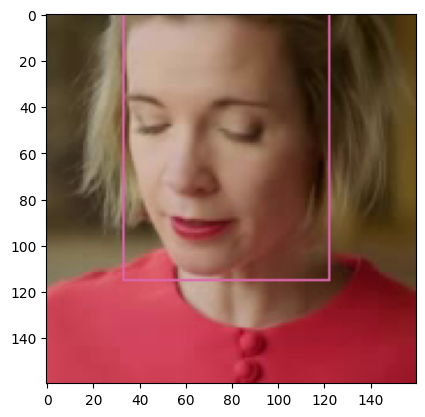

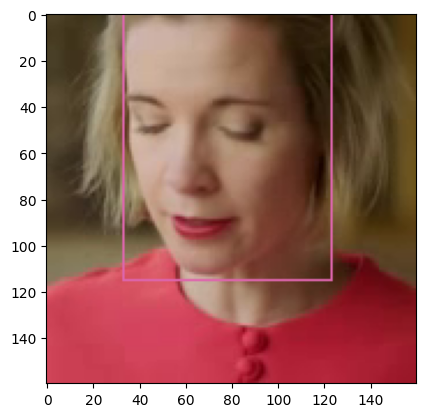

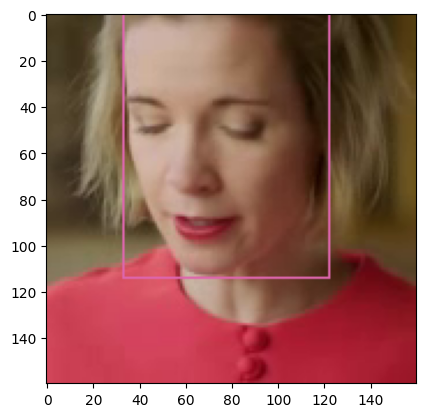

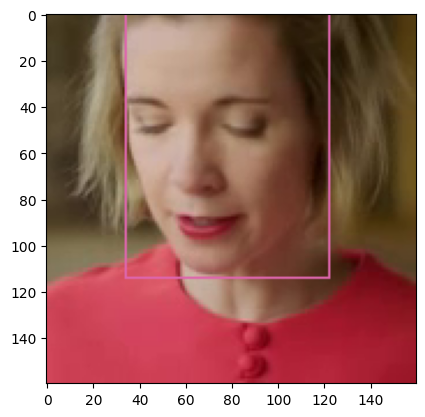

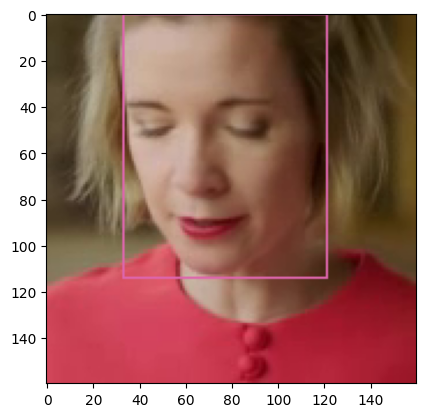

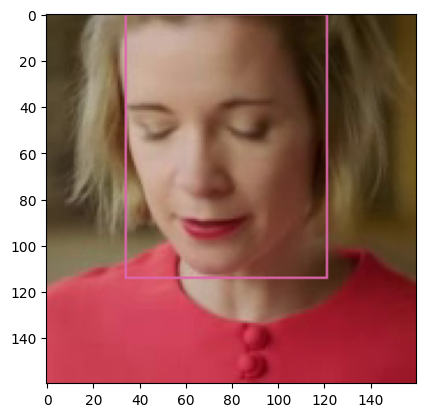

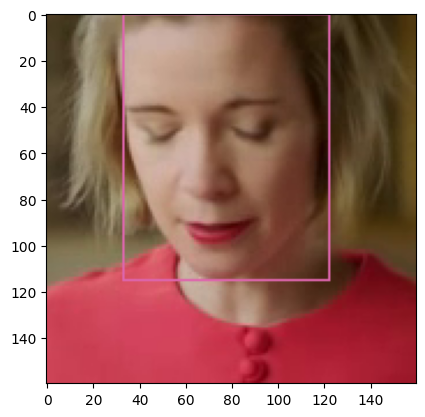

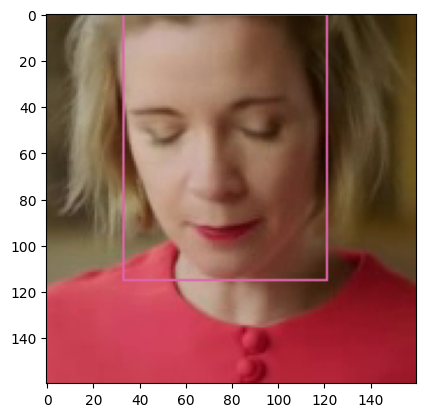

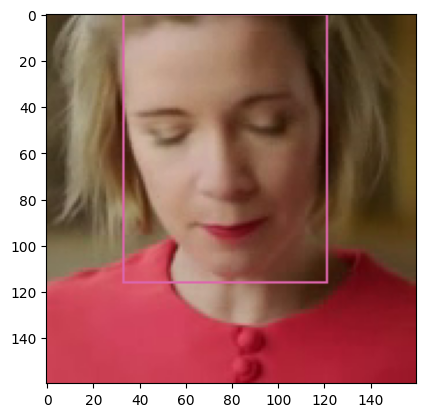

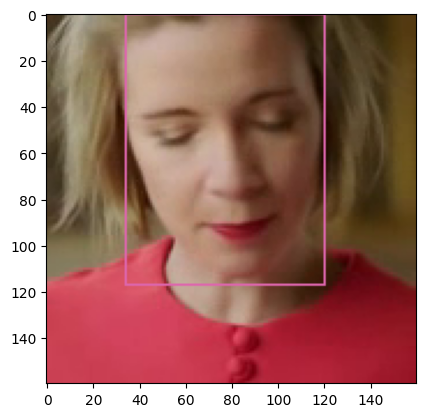

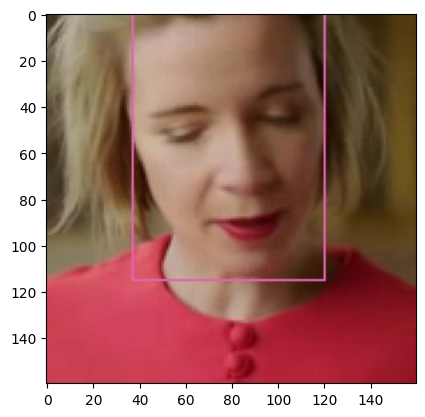

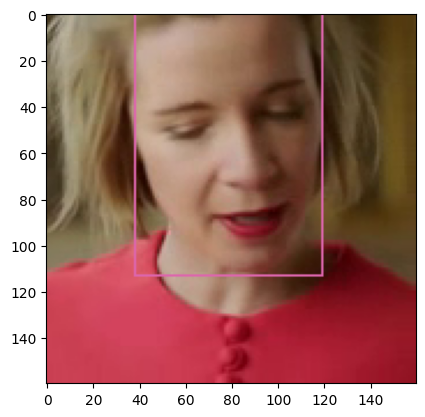

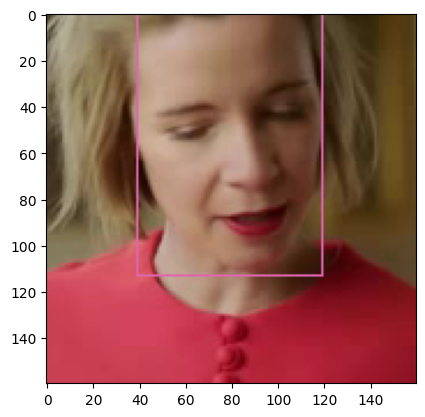

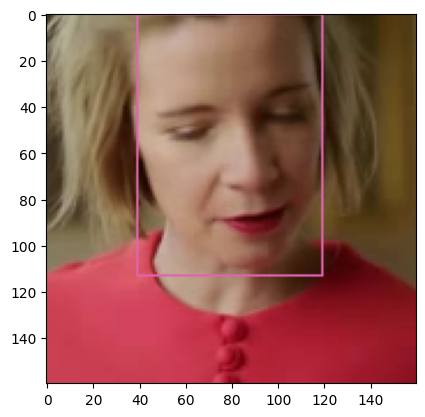

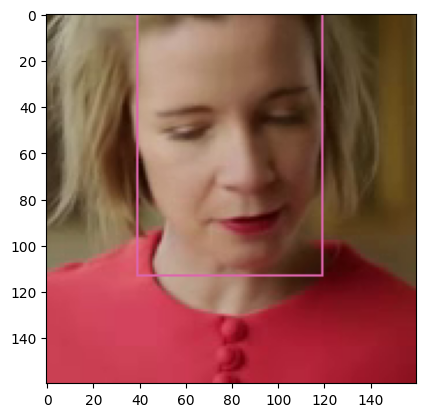

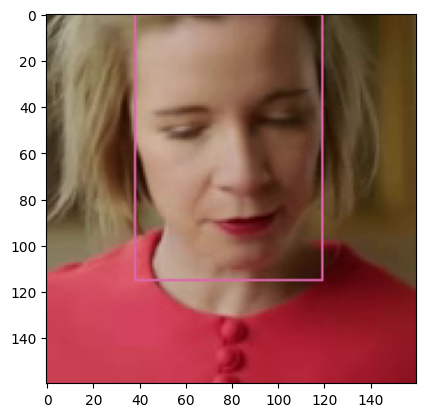

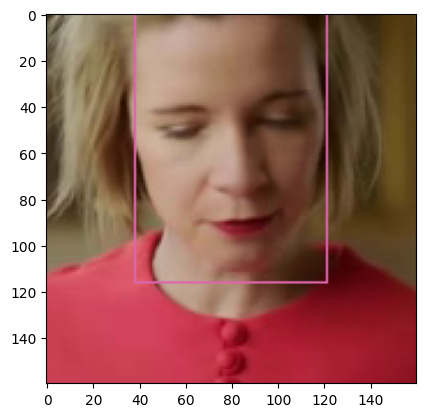

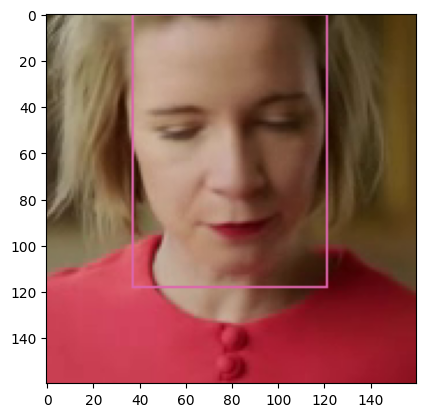

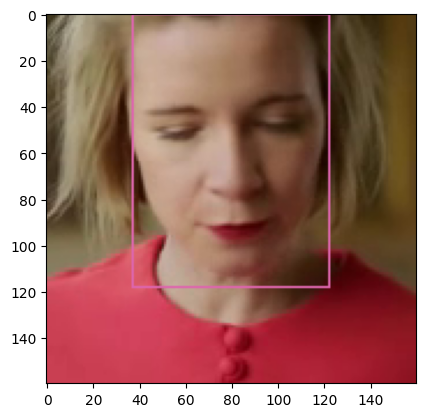

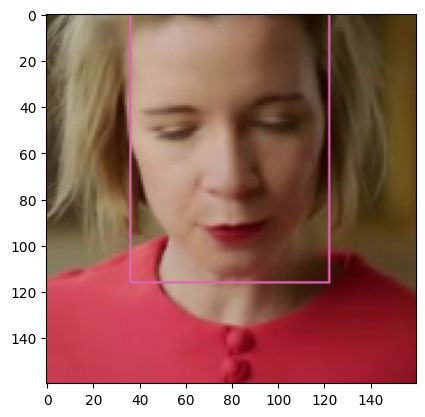

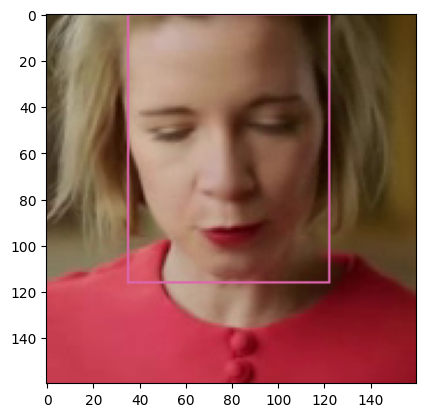

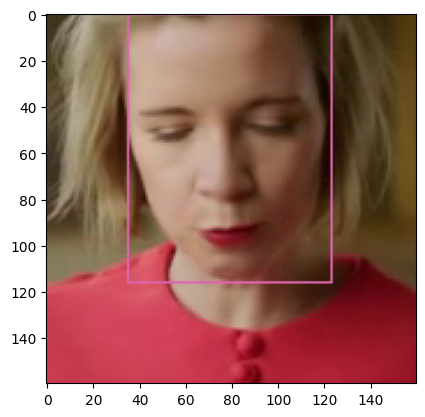

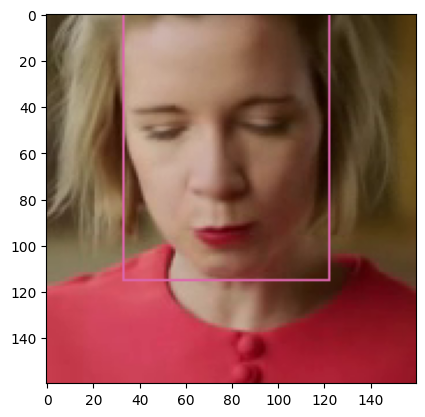

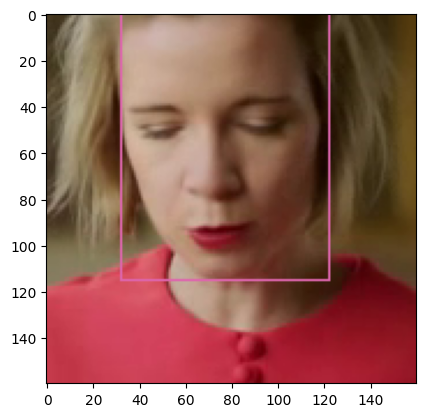

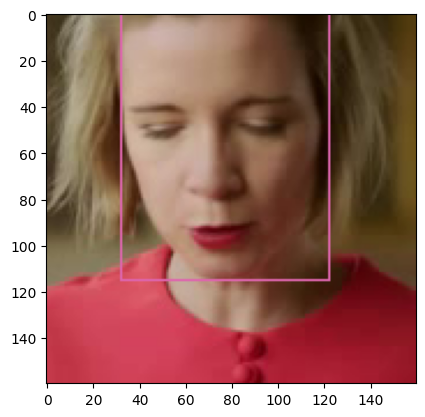

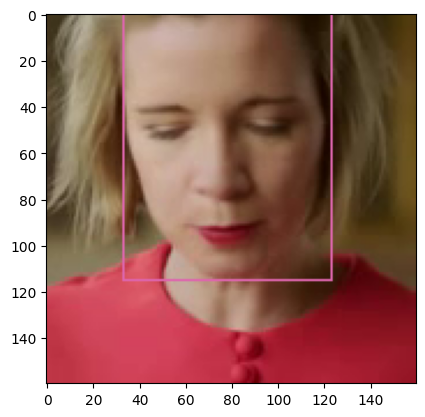

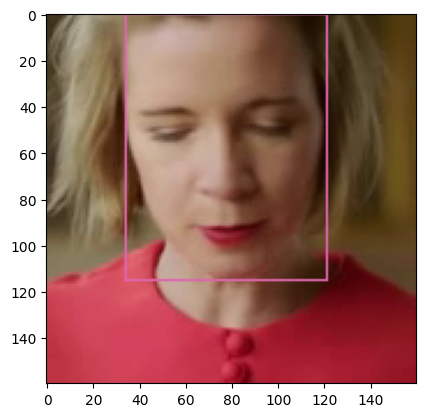

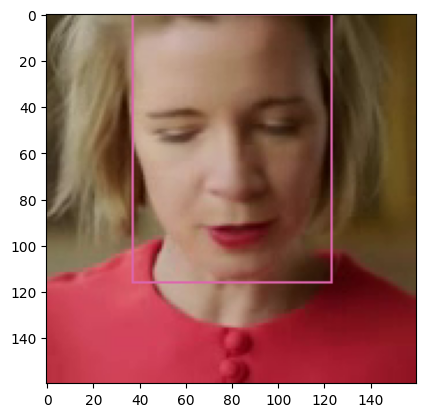

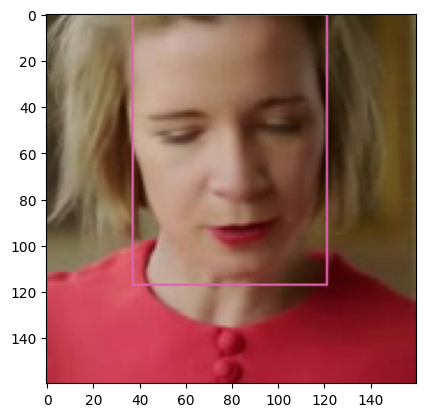

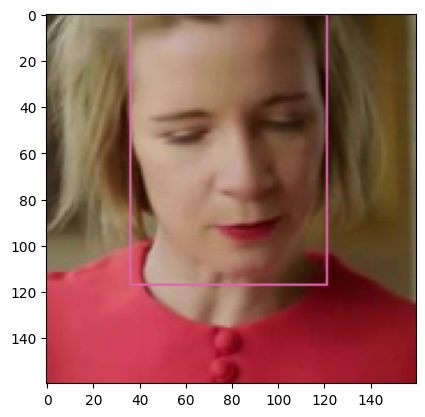

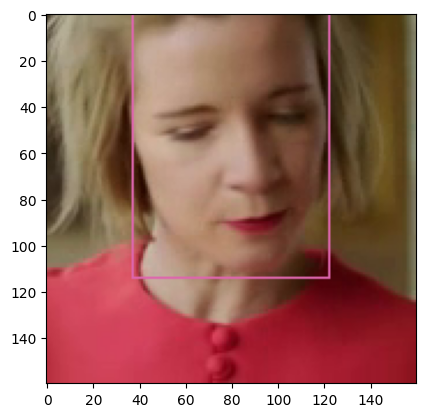

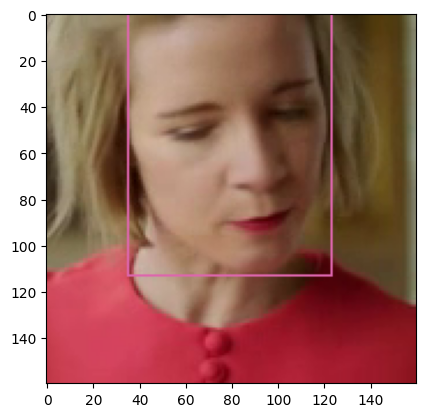

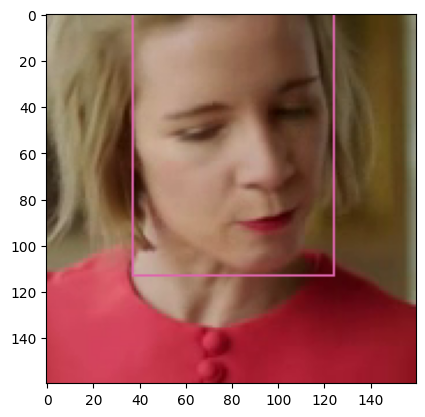

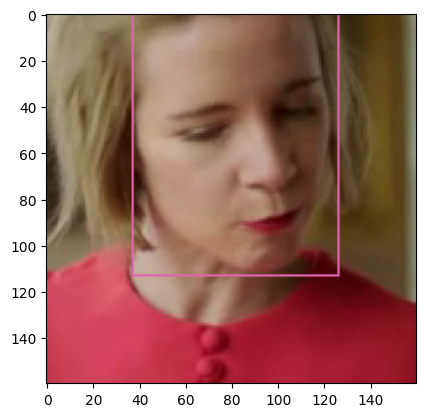

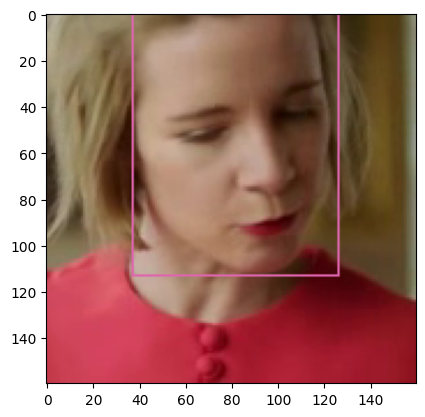

In [105]:
for i in range(len(vr)):
    frame = vr[i].asnumpy()
    bbox, kp=bboxes[i].astype(np.float32),kps[i].astype(np.float32)
    online_targets = tracker.update(bbox,kp,frame)
    for t in online_targets:
        tlwh = t.tlwh
        tid = t.track_id
        cv2.rectangle(frame,(int(tlwh[0]),int(tlwh[1])),(int(tlwh[0]+tlwh[2]),int(tlwh[1]+tlwh[3])),get_color(tid))
    plt.imshow(frame)
    plt.show()

In [93]:
online_targets[0].

array([ 28.35750083,  -7.70115361, 104.83950704, 123.63183487])

In [48]:
img = vr[0].asnumpy()
bbox = annotation['bboxes'][0][:2]
kps = annotation['kpss'][0][:2]

In [20]:
tracker.track_high_thresh

0.6

In [23]:
bboxes

[array([[ 37.12  ,  -5.984 , 122.2   , 120.94  ,   0.6367]], dtype=float16),
 array([[ 36.6   ,  -6.668 , 122.6   , 119.25  ,   0.6577]], dtype=float16),
 array([[ 37.06  ,  -5.758 , 120.94  , 117.94  ,   0.6626]], dtype=float16),
 array([[ 36.1  ,  -4.42 , 120.2  , 117.4  ,   0.667]], dtype=float16),
 array([[ 35.47  ,  -4.65  , 120.06  , 117.2   ,   0.6606]], dtype=float16),
 array([[ 35.3  ,  -5.2  , 120.5  , 117.3  ,   0.673]], dtype=float16),
 array([[ 34.97  ,  -4.8   , 120.5   , 117.6   ,   0.6646]], dtype=float16),
 array([[ 35.34 ,  -5.07 , 120.4  , 116.9  ,   0.657]], dtype=float16),
 array([[ 35.8  ,  -4.89 , 120.4  , 116.1  ,   0.674]], dtype=float16),
 array([[ 35.53 ,  -4.69 , 120.56 , 116.25 ,   0.667]], dtype=float16),
 array([[ 36.2 ,  -4.98, 121.1 , 114.56,   0.67]], dtype=float16),
 array([[ 35.34  ,  -4.684 , 121.    , 114.8   ,   0.6514]], dtype=float16),
 array([[ 36.1  ,  -4.168, 121.2  , 115.94 ,   0.664]], dtype=float16),
 array([[ 36.72  ,  -3.555 , 121.56  , 